<a href="https://colab.research.google.com/github/Lupama2/IntroCUDA/blob/main/GoogleColab/ICNPG_julia_logistic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Ejecutar en Google Colab

# Una transformación iterada y caótica: mapeo logístico

El [mapeo logístico](https://en.wikipedia.org/wiki/Logistic_map) es una relación de recurrencia polinómica de grado 2, que demuestra como un
comportamiento caótico complejo puede salir de una dinámica no-lineal extremadamente simple.
Fue propuesto en por el biólogo Robert May en 1976 como modelo demográfico en tiempo discreto.
Matemáticamente la relación de recurrencia es:

$$x_{n+1} = r x_n (1 - x_n )$$

donde $x_n$ es un numero real y se toma en el intervalo $[0, 1]$ y $r$, también real, en el intervalo $(0, 4]$.
Dependiendo del valor de $r$, este sistema dinámico discreto puede converger a un punto fijo, a un
comportamiento periódico o a uno caótico en función del tiempo discreto $n$. Este comportamiento
puede caracterizarse a través del exponente de Lyapunov asociada a una trajectoria de $\tau \gg 1$ pasos,

$$\lambda = 
\sum_{n=0}^{\tau-1}
\log(|r - 2 r x_n |)
$$

Para ver esto, para múltiples valores distintos de $r[i]$, haremos evolucionar un array de N variables
independientes $x[i]$ por un determinado tiempo $τ$, y calcularemos de paso el exponente de liapunov
$λ[i]$ asociado a cada trajectoria, para $i = 0, ..., N − 1$.


Hacer un programa en Julia que 
* Simule la evolución de $N$ variables logísticas $x^r_n$ en $\tau$ iteraciones. 
* Cada variable $x_n^r$ evoluciona sigue la ecuación logística con un valor de $r$ distribuído regularmente en el rango $[r_{\tt min},r_{\tt max}]$ con $r_{\tt min}>0$ y $r_{\tt max}<4$.
* Cada variable $x_n^r$ parte de una condición inicial aleatoria $x_0^r$ distribuída uniformemente en $(0,1)$.
* Imprimir un archivo de tres columnas con $(r,x_{\tau},\lambda)$ y graficar los puntos $x_{\tau}^r$ vs $r$, en color azul si $\lambda<0$ (no caótico), y rojo si $\lambda>0$ (caótico).

*  Traducir a python, usando numba o cupy, a Thrust y a Cuda C/C++.

In [ ]:
!wget https://julialang-s3.julialang.org/bin/linux/x64/1.8/julia-1.8.5-linux-x86_64.tar.gz


In [ ]:
!tar zxvf julia-1.8.5-linux-x86_64.tar.gz

In [ ]:
%%writefile packages.jl
import Pkg; Pkg.add("CUDA");
#import Pkg; Pkg.add("Plots")

Writing packages.jl


In [ ]:
!/content/julia-1.8.5/bin/julia packages.jl

In [ ]:
#@title Mapeo logístico en Julia con GPU

%%writefile logi.jl
using CUDA

function my_kernel(x::CuDeviceVector{Float32}, r::CuDeviceVector{Float32},l::CuDeviceVector{Float32},n_iterations)
	i = (blockIdx().x-1) * blockDim().x + threadIdx().x
	# el "-1" está porque Julia arranca sus índices desde cero

	acum=Float32(0.0);
	for p in 1:n_iterations
		@inbounds x[i] = r[i] * x[i] * (1 - x[i])
		@inbounds acum = acum + log(abs(r[i]-2.0*r[i]*x[i]) )
	end

	l[i]=acum/n_iterations;

	return nothing
end


# Define the parameters
N = 10000 #number of variables

r_min = Float32(3.5)
r_max = Float32(4.0)
r_range = range(r_min, r_max, length=N)  # range of logistic parameter

n_iterations = 10000 # number of map iterations

# Allocate memory on the GPU
x_d = CUDA.rand(Float32, N) # variables
r_d = CuArray{Float32}(r_range) # parameters
l_d = CUDA.zeros(Float32, N)  # Lyapunov exponent

# Alternative1: Iterate the logistic equation on the GPU using one raw kernel
@cuda threads=100 blocks=100 my_kernel(x_d,r_d,l_d,n_iterations)

# Alternative2: Iterate the logistic equation on the GPU using many broadcast kernels
#for p in 1:n_iterations
#	global x_d, r_d, l_d
#	CUDA.@. x_d  = (r_d .* x_d) .* (1.0 .- x_d)
#        CUDA.@. l_d = l_d .+ log( abs(r_d.-2*r_d.*x_d) ) 
#end



# Copy the results back to the CPU
x_range = Array{Float32}(x_d)
l_range = Array{Float32}(l_d)

using DelimitedFiles
data = hcat(r_range, x_range, l_range)
# Save the matrix as a two-column file
writedlm("logis.txt", data, '\t')

# Plot the results
#using Plots
#col = [xi < 0 ? "blue" : "red" for xi in l_range]
#scatter(r_range, x_range, color=col, markersize=1, legend=false, markerstrokecolor=col);
#xlabel!("r")
#ylabel!("x")

#savefig("myplot.png")


Overwriting logi.jl


Ejecutamos el código invocando a Julia

In [ ]:
!/content/julia-1.8.5/bin/julia logi.jl


real	0m31.389s
user	0m29.670s
sys	0m1.562s


In [ ]:
!head logis.txt

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np

def dibujame(file):
  # Load data from the file
  data = np.loadtxt(file)

  # Define a custom color map
  colors = ['blue', 'red']
  cmap = ListedColormap(colors)

  # Extract the columns for X, Y, and color
  x = data[:, 0]
  y = data[:, 1]

  mask = data[:, 2] > 0
  color = mask


  # Plot the data
  plt.scatter(x, y, s=1, c=color, cmap=cmap)

  # Add a colorbar
  plt.colorbar()

  # Set axis labels and title
  plt.xlabel('X')
  plt.ylabel('Y')
  plt.title('Logistic map')

  # Show the plot
  plt.show()



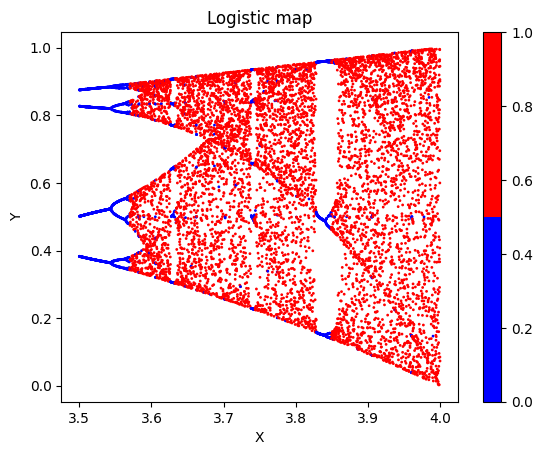

In [ ]:
dibujame("logis.txt")

Podemos ver que hizo por debajo con nvprof

In [ ]:
!nvprof /content/julia-1.8.5/bin/julia logi.jl

In [ ]:
#@title Mapeo logístico en Julia con CPU parallel

%%writefile logicpu.jl

using Base.Threads

function my_kernel!(x, r, l)


    Threads.@threads for i in eachindex(x, r, l)
      acum=Float32(0.0)
      for p in 1:n_iterations
          @inbounds x[i] = r[i] .* x[i] .* (1 - x[i])
          @inbounds acum = acum + log(abs(r[i]-2.0*r[i].*x[i]) )
      end
    	l[i]=acum/n_iterations
    end

    return nothing
end

# Define the parameters
N = 10000 #number of variables

r_min = Float32(3.5)
r_max = Float32(4.0)
r = range(r_min, r_max, length=N)  # range of logistic parameter

x = rand(Float32, N) # variables

l = zeros(Float32, N)  # Lyapunov exponent

n_iterations = 10000 # number of map iterations

my_kernel!(x,r,l)

using DelimitedFiles
data = hcat(r, x, l)
# Save the matrix as a two-column file
writedlm("logicpu.txt", data, '\t')


Overwriting logicpu.jl


In [ ]:
!/content/julia-1.8.5/bin/julia logicpu.jl


real	0m11.729s
user	0m11.507s
sys	0m0.254s


In [ ]:
!head logicpu.txt

3.5	0.87499726	-0.8710954
3.50005	0.3827928	-0.8635366
3.5001	0.50094527	-0.8547013
3.50015	0.82691014	-0.8429236
3.5002	0.38271233	-0.83960736
3.50025	0.38268557	-0.83103216
3.5003	0.50106704	-0.82198256
3.50035	0.5010977	-0.8156764
3.5004	0.501128	-0.8094383
3.5004501	0.8751078	-0.80214494


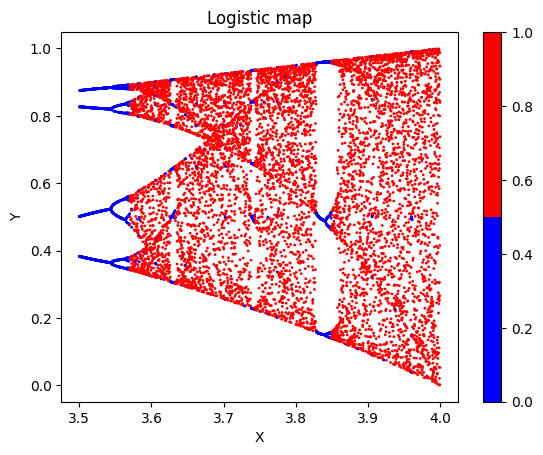

In [ ]:
dibujame("logicpu.txt")